In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")


In [36]:
# Merge datasets
data = pd.merge(transactions, customers, on="CustomerID")


In [37]:
# Feature Engineering
# Aggregate transaction data for each customer
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
customer_features = data.groupby('CustomerID').agg(
    total_value=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    num_transactions=('TransactionID', 'count'),
    unique_products=('ProductID', lambda x: x.nunique())
).reset_index()

In [38]:
# Normalize features for clustering
scaler = StandardScaler()
features_normalized = scaler.fit_transform(customer_features.iloc[:, 1:])

In [40]:
# Determine the optimal number of clusters using Davies-Bouldin Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_normalized)
    db_index = davies_bouldin_score(features_normalized, cluster_labels)
    db_scores.append((k, db_index))

In [41]:
# Select the number of clusters with the lowest DB Index
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 2


In [42]:
# Perform clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_normalized)

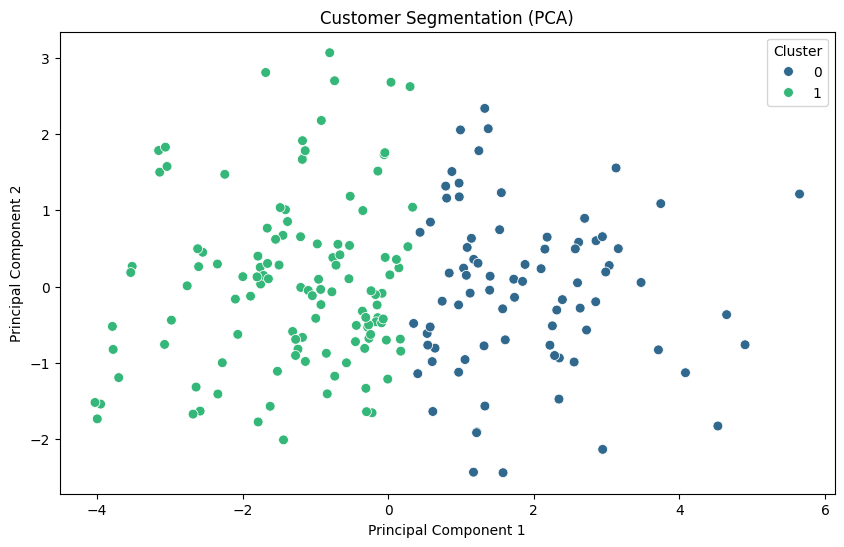

In [43]:
# Visualize clusters using PCA
def plot_clusters(data, labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        hue=labels,
        palette="viridis",
        s=50
    )
    plt.title("Customer Segmentation (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

plot_clusters(features_normalized, customer_features['Cluster'])

In [44]:
# Save cluster assignments
customer_features[['CustomerID', 'Cluster']].to_csv("Customer_Segments.csv", index=False)

In [45]:
# Print results
print("Clustering completed and saved to Customer_Segments.csv.")
for k in range(optimal_k):
    cluster_size = len(customer_features[customer_features['Cluster'] == k])
    print(f"Cluster {k}: {cluster_size} customers")

Clustering completed and saved to Customer_Segments.csv.
Cluster 0: 80 customers
Cluster 1: 119 customers
